# Amazon Fine Food Review Analysis

Data source : https://www.kaggle.com/snap/amazon-fine-food-reviews

EDA : https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/

This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories. Contents

Reviews.csv: Pulled from the corresponding SQLite table named Reviews in database.sqlite database.sqlite: Contains the table 'Reviews'

Data includes:

Reviews from Number of reviews : 568,454 Number of Users : 256,059 users Number of Products : 74,258 products Timespan : Oct 1999 - Oct 2012 Number of Attributes/Columns : 10 260 users with > 50 reviews

Attribute Information :

    Id
    ProductId : Unique identifier for the product
    UserId : Unqiue identifier for the user
    ProfileName : Profile name of the user
    HelpfulnessNumerator : Number of users who found the review helpful
    HelpfulnessDenominator : Number of users who indicated whether they found the review helpful or not
    Score : Rating between 1 and 5
    Time : Timestamp for the review
    Summary : Brief summary of the review
    Text : Text of the review



## Loading the dataset

In [41]:
import numpy as np
import sqlite3
import pandas as pd
import re
import sklearn

In [103]:
conn=sqlite3.connect('database.sqlite')

In [104]:
final_dataset=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score!=3 LIMIT 5000""",conn)

In [105]:
(final_dataset.head())

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


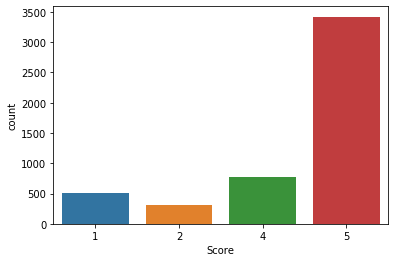

In [107]:
pos_neg_score=final_dataset['Score']
sns.countplot(final_dataset['Score'])

In [108]:
(type(pos_neg_score))

pandas.core.series.Series

In [109]:
def position(x):
    if x>3:
        return 'positive'
    return 'negative'


In [110]:
fin_pos_neg=pos_neg_score.map(position)

In [111]:
print(fin_pos_neg.head())

0    positive
1    negative
2    positive
3    negative
4    positive
Name: Score, dtype: object


In [112]:
final_dataset['Score']=fin_pos_neg

In [113]:
print(final_dataset.head())
print(final_dataset.shape)

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

In [114]:
final_dataset=final_dataset[final_dataset.HelpfulnessNumerator<=final_dataset.HelpfulnessDenominator]

In [115]:
print(final_dataset['Score'].value_counts())

positive    4187
negative     813
Name: Score, dtype: int64


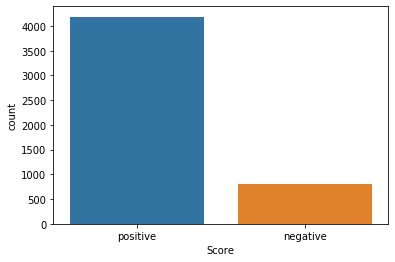

In [116]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(final_dataset['Score'])

## Text Preprocessing

* Removing the html tags
* Removing pancuations or special charector like or, #...
* check if the word is made up of english language or alphanumeric
* check to see if length of the word greater then 2.
* convert the words to lower case
* remove stop words
* Final Snowball stemming the word

In [46]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [47]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [48]:
from bs4 import BeautifulSoup

In [49]:
# Combining all the above stundents 

from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
#for final['text']
for sentance in tqdm(final_dataset['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████| 5000/5000 [00:01<00:00, 2528.54it/s]


In [53]:
preprocessed_reviews[100]
print(type(preprocessed_reviews))

<class 'list'>


## Featurization or Vectorization
### Applying Naive_bayes on BoW

In [117]:
from sklearn.model_selection import train_test_split

In [118]:
y=list(final_dataset['Score'])
x_train,x_test,y_train,y_test=train_test_split(preprocessed_reviews,y,test_size=0.3)

In [119]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))
print(type(x_train))

3500
1500
3500
1500
<class 'list'>


In [120]:
from sklearn.feature_extraction.text import CountVectorizer

In [121]:
vec=CountVectorizer()
bow_xtrain_vec=vec.fit_transform(x_train).todense()
bow_x_test_vec=vec.transform(x_test).todense()


In [122]:
print(bow_xtrain_vec.shape)
print(bow_x_test_vec.shape)

(3500, 10885)
(1500, 10885)


In [123]:
from sklearn.naive_bayes import MultinomialNB

In [124]:
obj=MultinomialNB(alpha=1)
obj.fit(bow_xtrain_vec,y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [125]:
pred=obj.predict(bow_x_test_vec)

In [126]:
from sklearn.metrics import accuracy_score

In [127]:
print('Accuracy for alpha=0.1 : ',accuracy_score(y_test,pred))

Accuracy for alpha=0.1 :  0.8866666666666667


In [158]:
from sklearn.model_selection import cross_val_score

### without cross validation 

For alpha= 0.0001  Accuracy:  86.8 %

For alpha= 0.001  Accuracy:  87.4 %

For alpha= 0.01  Accuracy:  88.4 %

For alpha= 0.1  Accuracy:  90.13333333333333 %

For alpha= 1  Accuracy:  88.66666666666667 %

For alpha= 10  Accuracy:  83.53333333333333 %

For alpha= 100  Accuracy:  83.53333333333333 %

For alpha= 1000  Accuracy:  83.53333333333333 %

For alpha= 10000  Accuracy:  83.53333333333333 %



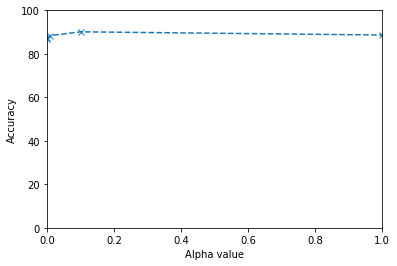

Best alpha value is  0.1 with accuracy : 90.13333333333333 %


In [193]:
#aa=['0.0001','0.001','0.01','0.1','1','10','100','1000','10000']
a=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
acu={}
score_list=[]
for i in a:
    obj=MultinomialNB(alpha=i)
    obj.fit(bow_xtrain_vec,y_train)
    #score=cross_val_score(obj,bow_xtrain_vec,y_train,cv=10,scoring='accuracy')
    pred=obj.predict(bow_x_test_vec)
    score=accuracy_score(y_test,pred)
    acu[i]=score*100
    score_list.append(score*100)
    print('For alpha=',i,' Accuracy: ',score*100,'%\n')

plt.plot(a,score_list,linestyle='dashed',marker='x',markerfacecolor='red')
#sns.barplot(aa,score_list)
plt.ylim(0,100)
plt.xlim(-0.0001,1)
plt.xlabel('Alpha value')
plt.ylabel('Accuracy')
plt.show()
best_alpha=max(acu,key=acu.get)
print('Best alpha value is ', best_alpha ,'with accuracy :',acu[best_alpha],'%')

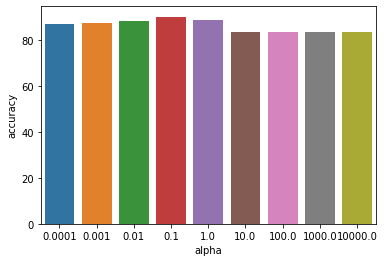

In [210]:
df=pd.DataFrame(a,columns=['alpha'])
#print(df)
df['accuracy']=score_list
sns.barplot(df['alpha'],df['accuracy'])
plt.show()


### Cross validation of 10

In [211]:
a=[0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
acu={}
score_list=[]
for i in a:
    obj=MultinomialNB(alpha=i)
    obj.fit(bow_xtrain_vec,y_train)
    score=cross_val_score(obj,bow_xtrain_vec,y_train,cv=10,scoring='accuracy')
    #pred=obj.predict(bow_x_test_vec)
    #score=accuracy_score(y_test,pred)
    score_list.append(score.mean()*100)
    acu[i]=score.mean()*100
    print('For alpha=',i,' Accuracy: ',score.mean()*100,'%\n')
best_alpha=max(acu,key=acu.get)
print('Best alpha value is ', best_alpha ,'with accuracy :',acu[best_alpha],'%')   

For alpha= 0.0001  Accuracy:  85.22774040137936 %

For alpha= 0.001  Accuracy:  85.51402821947235 %

For alpha= 0.01  Accuracy:  86.056316961188 %

For alpha= 0.1  Accuracy:  86.28546145566203 %

For alpha= 1  Accuracy:  86.59860663585593 %

For alpha= 10  Accuracy:  83.85736396681955 %

For alpha= 100  Accuracy:  83.80030250975811 %

For alpha= 1000  Accuracy:  83.82879253824814 %

For alpha= 10000  Accuracy:  83.82879253824814 %

Best alpha value is  1 with accuracy : 86.59860663585593 %


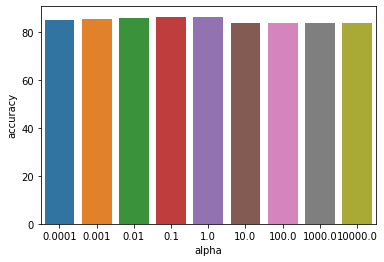

In [212]:
df=pd.DataFrame(a,columns=['alpha'])
#print(df)
df['accuracy']=score_list
sns.barplot(df['alpha'],df['accuracy'])
plt.show()
